In [4]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

In [2]:
PATH = 'F:/[Base] Code/DataSets/airbus-ship-detection'
print(os.listdir(PATH))

['sample_submission_v2.csv', 'test_v2', 'train_ship_segmentations_v2.csv', 'train_v2']


In [3]:
train_image_dir = PATH + '/train_v2'
test_image_dir = PATH + '/test_v2'
train_image_dir

'F:/[Base] Code/DataSets/airbus-ship-detection/train_v2'

In [5]:
# run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def multi_rle_encode(img):
    labels = label(img)
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

def mask_overlay(image, mask, color=(0, 1, 0)):
    """
    Helper function to visualize mask on the top of the image
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0
    img[ind] = weighted_sum[ind]    
    return img

def imshow(img, mask, title=None):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    mask = mask.numpy().transpose((1, 2, 0))
    mask = np.clip(mask, 0, 1)
    fig = plt.figure(figsize = (6,6))
    plt.imshow(mask_overlay(img, mask))
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

In [6]:
masks = pd.read_csv(PATH + '/train_ship_segmentations_v2.csv')
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0], 'unique images found')
masks.head()

231723 masks found
192556 unique images found


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


---
## Randomly Drop The Empty Images
we choose to randomly drop the empty images to get a better balanced group with more ships to train

In [7]:
print(masks.shape[0])
masks = masks.drop(masks[masks.EncodedPixels.isnull()].sample(150000,random_state=42).index)
print(masks.shape[0])
masks.sample(3)

231723
81723


,ImageId,EncodedPixels
196527,d94f5c24b.jpg,352500 2 353264 6 354030 9 354798 9 355567 8 3...
88453,619e3f7d3.jpg,295292 4 296060 11 296828 18 297596 25 298363 ...
103241,71ce4a848.jpg,499471 2 500239 4 501006 7 501774 10 502541 13...


## Split Datasets
we choose to split original dataset into training sets and validation sets to vanish the bias<br>
split rate — 19 : 1

In [8]:
from sklearn.model_selection import train_test_split
unique_img_ids = masks.groupby('ImageId').size().reset_index(name='counts')
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.05, 
                 stratify = unique_img_ids['counts'],
                 random_state=42
                )
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')
train_df.head(3)

77636 training masks
4087 validation masks


,ImageId,EncodedPixels,counts
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
1,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5
2,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,5


In [9]:
train_df['counts'] = train_df.apply(lambda c_row: c_row['counts'] if isinstance(
    c_row['EncodedPixels'], str
) else 0, 1)
valid_df['counts'] = valid_df.apply(lambda c_row: c_row['counts'] if isinstance(
    c_row['EncodedPixels'], str
) else 0, 1)

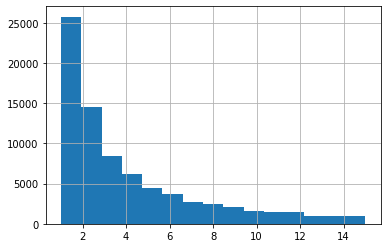

In [10]:
train_df['counts'].hist(bins = 15)

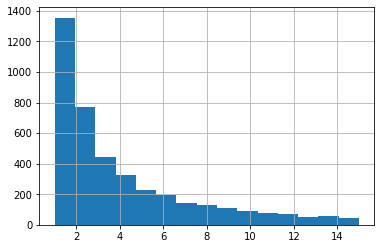

In [11]:
valid_df['counts'].hist(bins = 15)

In [12]:
print(train_df.ImageId.nunique(), 'unique images in train set')
print(valid_df.ImageId.nunique(),'unique images in test set')

40428 unique images in train set
2128 unique images in test set
